In [1]:
from libs.lfgenerator import TwoPart, Shift, Exponential, ExpPeak
import matplotlib.pyplot as plt
import numpy as np

Any linear, continuous funcional $H_t$ can be represented by the following integration,

$$\begin{align*}
H_t(\bm x) = \int_{-\infty}^{\infty} \rho(t,s)^\top x(s) ds.
\end{align*}$$

Properties such as memory and smoothness are characterised by the function $\rho$. We generate different dataset by specifying different $\rho$.

Shift is a dataset which simply shift the input sequence by some distance.

To initialize a dataset we specify some configs. Defauly configs includes
`{'input_dim': 1,'output_dim': 1,'data_num': 128,'path_len': 32, 'dt': 0.1}` which are applicable to every generator. Here the output_dim are always assumed to be 1. `dt` specifies the step size for the discretezation, i.e. with path length=32 and dt=0.1 we are considering sequence defined on $[0,3.2]$

In [2]:
generator = Shift({'input_dim':1, 'path_len':16 ,'shift':[3]})
# There are also some extra configs for each specific generator, for example for the shift generator we need to specify the distance we want to shift. 
# For this generator we always dt=1 to avoid issues.

generator.generate(data_num=1)
# use the generate method to generate data. the return is a tuple (input, output)
# input and output have shape (data_num, path_length, dim)

(array([[[-0.01841987],
         [-0.00293785],
         [ 0.09628093],
         [ 0.09182565],
         [-0.20091892],
         [ 0.07664181],
         [ 0.10676053],
         [-0.08313156],
         [-0.04772581],
         [-0.07513038],
         [-0.00333   ],
         [-0.0077284 ],
         [ 0.0113646 ],
         [-0.22877513],
         [ 0.05306404],
         [ 0.02882131]]]),
 array([[[ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [-0.01841987],
         [-0.00293785],
         [ 0.09628093],
         [ 0.09182565],
         [-0.20091892],
         [ 0.07664181],
         [ 0.10676053],
         [-0.08313156],
         [-0.04772581],
         [-0.07513038],
         [-0.00333   ],
         [-0.0077284 ],
         [ 0.0113646 ]]]))

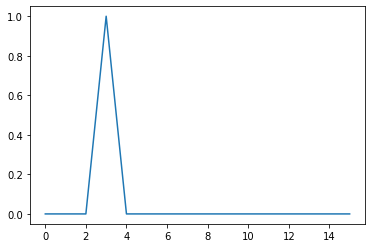

In [3]:
plt.plot(generator.plot_rho(d=0, causal=True))
# plot_rho method returns an array for plot rho
# d specifies dimension of rho
# causal specifies whether the relation is causal or not. If it is causal then we plot rho(t-s) 

Exponential is a genearte where $\rho(t,s) = (e^{-\lambda_0 (t-s)}, \dots,e^{-\lambda_d (t-s)} )$, we need to specify the $\lambda s$

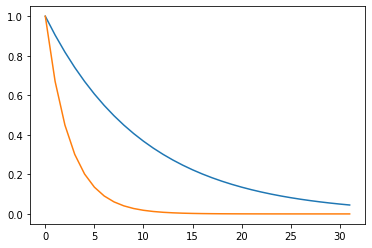

In [4]:
generator = Exponential({'input_dim':2, 'path_len':32, 'lambda':[1,4]})
plt.plot(generator.plot_rho(d=0, causal=True))
plt.plot(generator.plot_rho(d=1, causal=True))

TwoPart is defined by $\rho = e^{-\sigma*(t-s-c)^2}$

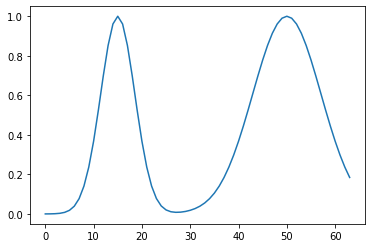

In [9]:
generator = TwoPart({'centers': [[1.5, 5]],'sigmas':[[4, 1]],'path_len':64})
plt.plot(generator.plot_rho(d=0, causal=True))

ExpPeak is defined by $\rho = e^{-\lambda (t-s)} + e^{-\sigma*(t-s-c)^2}$, which is a exponential with a peak.

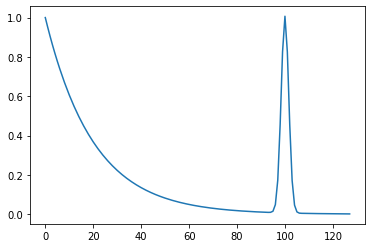

In [12]:
generator = ExpPeak({'lambda':[0.5], 'centers': [10],'sigmas':[20],'path_len':128})
plt.plot(generator.plot_rho(d=0, causal=True))

The RNN we considers is 
$$\begin{align*}
h_{t+1} &= \sigma(Wh_{t} + Ux_{t} + b)\\
o_{t+1} &= c^\top h_{t+1}
\end{align*}$$ 
or a residual version writes as,
$$\begin{align*}
h_{t+1} &= h_t+ \sigma(Wh_{t} + Ux_{t} + b)\\
o_{t+1} &= c^\top h_{t+1}
\end{align*}$$ 